In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

### Part 1

##### Load the data and plot some of it

   V1   V2   V3   V4     V5     V6     V7     V8     V9    V10  ...   V248  \
1   0 -1.0 -1.0 -1.0 -1.000 -1.000 -0.972  0.178  1.000  0.689  ...  0.522   
2   9 -1.0 -1.0 -1.0 -1.000 -1.000 -0.815  0.268  0.640  0.869  ... -0.090   
3   8 -1.0 -1.0 -1.0 -1.000 -0.987 -0.806 -0.169  0.350  0.986  ...  0.873   
4  -9 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -0.851  0.668 -0.858  ...  0.832   
5   8 -1.0 -1.0 -1.0 -0.928  0.162 -0.014 -0.210  0.999  1.000  ... -1.000   

    V249   V250   V251   V252   V253  V254  V255  V256  V257  
1  0.940  1.000  0.400 -0.337 -0.954  -1.0  -1.0  -1.0  -1.0  
2  0.990 -0.381 -1.000 -1.000 -1.000  -1.0  -1.0  -1.0  -1.0  
3  1.000  1.000  0.832  0.196 -0.714  -1.0  -1.0  -1.0  -1.0  
4 -0.017 -0.847 -1.000 -1.000 -1.000  -1.0  -1.0  -1.0  -1.0  
5 -0.683  0.711  1.000  0.320 -0.928  -1.0  -1.0  -1.0  -1.0  

[5 rows x 257 columns]
Image dimensions: 16x16


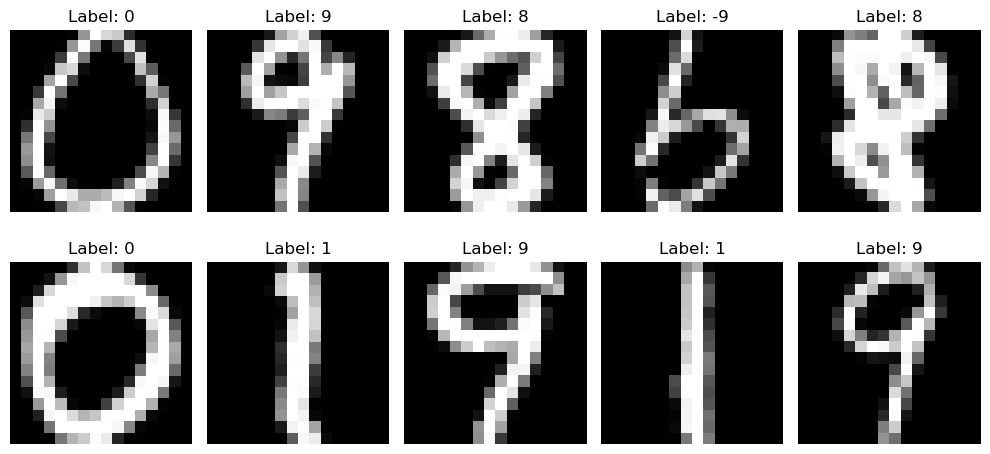

In [3]:
# Load the file 
data = pd.read_csv('Numbers.txt', delim_whitespace=True)

# Print the first few rows to inspect the data structure
print(data.head())

# Separate the label (first column) and the image pixels (remaining columns)
labels = data.iloc[:, 0].astype(int).values
images = data.iloc[:, 1:].values

# Determine image dimensions. Here we assume 256 pixels per image, i.e., 16x16.
img_dim = int(np.sqrt(images.shape[1]))
print("Image dimensions: {}x{}".format(img_dim, img_dim))

# Plot some images (for example, the first 10)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    # Reshape the flat image into 16x16
    img = images[i].reshape(img_dim, img_dim)
    # Show the image. Using cmap='gray' for better visualization.
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


##### Prepare for training models

In [4]:
# Split the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

In [5]:
print("Data shapes:", x_train.shape, x_test.shape)

Data shapes: (1400, 256) (600, 256)


In [6]:
# Define classifier in pipeline
pipeline = {
    'LDA': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearDiscriminantAnalysis())
    ]),
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ])
}

##### Perform cross-validation to compare the different models without tuning.

In [7]:
print("\n=== 1. Comparison without tuning ===")
cv_results = {}
for name, pipe in pipeline.items():
    scores = cross_val_score(pipe, x_train, y_train, cv=5, scoring='accuracy')
    cv_results[name] = scores
    print(f"{name}: 5-fold CV Accuracy = {np.mean(scores):.4f}")



=== 1. Comparison without tuning ===
LDA: 5-fold CV Accuracy = 0.8686
LogisticRegression: 5-fold CV Accuracy = 0.9121
KNN: 5-fold CV Accuracy = 0.9086


##### Perform cross-validation to tune *and* compare the different models - this requires you to use a double-CV or hold-out+CV  as mentioned in class.

In [8]:
print("\n=== 2. Tuning and comparison (Nested CV) ===")
param_grids = {
    'LDA': {
        # For LDA, there is not much parameters to tune; we could try solver options
        'clf__solver': ['svd', 'lsqr']
    },
    'LogisticRegression': {
        'clf__C': [0.01, 0.1, 1, 10, 100]
    },
    'KNN': {
        # Here we tune the number of K. small K is very flexible, large K is more rigid
        "clf__n_neighbors": [1, 3, 5, 7, 9] 
    }
}

nested_cv_results= {}
for name, pipe in pipeline.items():
    grid = GridSearchCV(pipe, param_grids[name], cv=5, scoring='accuracy')
    # Outer CV to evaluate tune model
    nested_scores = cross_val_score(grid, x_train, y_train, cv=5, scoring='accuracy')
    print(nested_scores)
    nested_cv_results[name] = nested_scores
    print(f"{name}: Nested CV Accuracy = {np.mean(nested_scores):.4f}")

# Fit tuned models in the training dataset and record training error
tuned_models = {}
train_scores = {}
for name, pipe in pipeline.items():
    grid = GridSearchCV(pipe, param_grids[name], cv=5, scoring='accuracy')
    grid.fit(x_train, y_train)
    tuned_models[name] = grid.best_estimator_
    train_pred = grid.predict(x_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_scores[name] = train_acc
    print(f"{name}: Best params = {grid.best_estimator_}, Training Accuracy = {train_acc:.4f}")

# Evaluate tuned model on the test dataset
test_scores = {}
for name, model in tuned_models.items():
    test_pred = model.predict(x_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_scores[name] = test_acc
    print(f"{name}: Test Accuracy = {test_acc:.4f}")


=== 2. Tuning and comparison (Nested CV) ===
[0.87857143 0.86071429 0.86071429 0.875      0.86785714]
LDA: Nested CV Accuracy = 0.8686
[0.91785714 0.90357143 0.90714286 0.93214286 0.92142857]
LogisticRegression: Nested CV Accuracy = 0.9164
[0.91428571 0.90714286 0.92142857 0.94285714 0.90714286]
KNN: Nested CV Accuracy = 0.9186
LDA: Best params = Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LinearDiscriminantAnalysis())]), Training Accuracy = 0.9564
LogisticRegression: Best params = Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=0.1, max_iter=1000))]), Training Accuracy = 0.9921
KNN: Best params = Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', KNeighborsClassifier(n_neighbors=1))]), Training Accuracy = 1.0000
LDA: Test Accuracy = 0.8817
LogisticRegression: Test Accuracy = 0.9167
KNN: Test Accuracy = 0.9100


In [10]:
print("\n=== 3. Optimism: Training vs. Nested CV vs. Test Accuracy ===")
for name in pipeline.keys():
    cv_acc = np.mean(nested_cv_results[name])
    print(f"{name} -> Training Accuracy: {train_scores[name]:.3f}, Nested CV Accuracy: {cv_acc:.3f}, Test Accuracy: {test_scores[name]:.3f}")



=== 3. Optimism: Training vs. Nested CV vs. Test Accuracy ===
LDA -> Training Accuracy: 0.956, Nested CV Accuracy: 0.869, Test Accuracy: 0.882
LogisticRegression -> Training Accuracy: 0.992, Nested CV Accuracy: 0.916, Test Accuracy: 0.917
KNN -> Training Accuracy: 1.000, Nested CV Accuracy: 0.919, Test Accuracy: 0.910


### Part 2

##### Small training data: 100, 500, 1000

In [ ]:
# Randomly select 100 indices
random_indices = np.random.choice(len(images), size=100, replace=False)

# Select the corresponding images and labels
images_100 = images[random_indices]
labels_100 = labels[random_indices]

In [17]:
# Select exactly 100 samples while preserving label distribution
train_images,_, train_labels,_ = train_test_split(
    images, 
    labels, 
    train_size=100, 
    stratify=labels, 
    random_state=42
)

In [19]:
print(train_images.shape)

(100, 256)


In [26]:
train_sizes = [1000, 500, 100]
results = {name: [] for name in pipeline.keys()}  # Store accuracy results

# Loop through different training set sizes
for train_size in train_sizes:
    # Sample `train_size` images from the full training set
    X_train_sample, _, y_train_sample, _ = train_test_split(
        x_train, y_train, train_size=train_size, random_state=42, stratify=y_train)
    
    print(f"\nTraining on {train_size} images...")
    # Check the distribution of labels in your sampled training data
    label_distribution = Counter(y_train_sample)
    print("Label distribution in training data:", label_distribution)

    for name, pipe in pipeline.items():
        # Train model
        pipe.fit(X_train_sample, y_train_sample)
        
        # Evaluate on the fixed test set
        test_pred = pipe.predict(x_test)
        test_acc = accuracy_score(y_test, test_pred)
        
        results[name].append(test_acc)
        print(f"{name}: Test Accuracy = {test_acc:.3f}")


Training on 1000 images...
Label distribution in training data: Counter({0: 174, 1: 154, -2: 111, 6: 101, 2: 100, -9: 94, 5: 93, 9: 89, 8: 84})
LDA: Test Accuracy = 0.863
LogisticRegression: Test Accuracy = 0.917
KNN: Test Accuracy = 0.897

Training on 500 images...
Label distribution in training data: Counter({0: 87, 1: 77, -2: 55, 2: 50, 6: 50, 5: 47, -9: 47, 9: 45, 8: 42})
LDA: Test Accuracy = 0.760
LogisticRegression: Test Accuracy = 0.883
KNN: Test Accuracy = 0.870

Training on 100 images...
Label distribution in training data: Counter({0: 18, 1: 15, -2: 11, 6: 10, 2: 10, -9: 9, 8: 9, 5: 9, 9: 9})
LDA: Test Accuracy = 0.573
LogisticRegression: Test Accuracy = 0.832
KNN: Test Accuracy = 0.710
